In [17]:
import numpy as np
import csv
from collections import defaultdict, Counter
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.optimize import nnls

### Dataset preparation

In [18]:
# reading from raw input files to get movie name, id and genres
movies = defaultdict(dict)
all_genres = set()
movies_genre_df_list = []
with open('./Dataset_MovieSummaries/movie.metadata.tsv', encoding='utf-8') as f:
    movie_metadata = csv.reader(f, delimiter='\t')

    # Extracting genres from the metadata
    for line in movie_metadata:
        values = json.loads(line[8]).values()
        genres = list(values)
        all_genres.update(values)
        movies_genre_df_list.append([int(line[0]), line[2], tuple(genres)])


In [19]:
movies_genre = pd.DataFrame(movies_genre_df_list, columns = ['movie_id', 'movie_name', 'genres'])
movies_genre

,movie_id,movie_name,genres
0,975900,Ghosts of Mars,"(Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"(Mystery, Biographical film, Drama, Crime Drama)"
2,28463795,Brun bitter,"(Crime Fiction, Drama)"
3,9363483,White Of The Eye,"(Thriller, Erotic thriller, Psychological thri..."
4,261236,A Woman in Flames,"(Drama,)"
...,...,...,...
81736,35228177,Mermaids: The Body Found,"(Drama,)"
81737,34980460,Knuckle,"(Biographical film, Drama, Documentary)"
81738,9971909,Another Nice Mess,"(Satire, Comedy)"
81739,913762,The Super Dimension Fortress Macross II: Lover...,"(Science Fiction, Japanese Movies, Adventure, ..."


In [20]:
movie_descriptions = []
with open('./Dataset_MovieSummaries/plot_summaries.txt', encoding='utf-8') as f2:
    movie_description = csv.reader(f2, delimiter='\t')
    
    for line in movie_description:
        
        description = line[1]
        id_ = int(line[0])
        movie_descriptions.append([id_, description])
summary_df = pd.DataFrame(movie_descriptions, columns = ['movie_id', 'summary'])

In [21]:
summary_df

,movie_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


In [22]:
movies_genre = pd.merge(movies_genre, summary_df, on='movie_id', how='inner')
movies_genre

,movie_id,movie_name,genres,summary
0,975900,Ghosts of Mars,"(Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,White Of The Eye,"(Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,A Woman in Flames,"(Drama,)","Eva, an upper class housewife, becomes frustra..."
3,18998739,The Sorcerer's Apprentice,"(Family Film, Fantasy, Adventure, World cinema)","Every hundred years, the evil Morgana returns..."
4,6631279,Little city,"(Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."
...,...,...,...,...
42199,23851782,The Ghost Train,"(Crime Fiction, Thriller, Comedy, Supernatural)",{{plot}} The film opens with a Great Western e...
42200,35228177,Mermaids: The Body Found,"(Drama,)",Two former National Oceanic Atmospheric Admini...
42201,34980460,Knuckle,"(Biographical film, Drama, Documentary)",{{No plot}} This film follows 12 years in the ...
42202,913762,The Super Dimension Fortress Macross II: Lover...,"(Science Fiction, Japanese Movies, Adventure, ...","The story takes place in the year 2092,The Sup..."


In [23]:
# remove genres that occur less than 3000 times
genre_counts = Counter(list(item for sublist in movies_genre['genres'] for item in sublist))
genres_to_remove = [genre for genre, count in genre_counts.items() if count < 3000]
genres_to_remove.append('Comedy film')
def remove_sparse_genres(genre_list):
    return tuple([genre for genre in genre_list if genre not in  genres_to_remove])
movies_genre['genres'] = movies_genre['genres'].apply(remove_sparse_genres)
genres_labels = list(set(item for sublist in movies_genre['genres'] for item in sublist))

In [24]:
mlb = MultiLabelBinarizer()
genres_binary = mlb.fit_transform(movies_genre['genres'])
genres_binary_df = pd.DataFrame(genres_binary, columns=mlb.classes_)
movies_genres_df = pd.concat([movies_genre[['movie_id', 'movie_name']], genres_binary_df], axis=1)

In [25]:
movies_genres_df

,movie_id,movie_name,Action,Action/Adventure,Adventure,Black-and-white,Comedy,Crime Fiction,Drama,Family Film,Horror,Indie,Romance Film,Short Film,Thriller,World cinema
0,975900,Ghosts of Mars,1,0,1,0,0,0,0,0,1,0,0,0,1,0
1,9363483,White Of The Eye,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,261236,A Woman in Flames,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,18998739,The Sorcerer's Apprentice,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,6631279,Little city,0,0,0,0,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42199,23851782,The Ghost Train,0,0,0,0,1,1,0,0,0,0,0,0,1,0
42200,35228177,Mermaids: The Body Found,0,0,0,0,0,0,1,0,0,0,0,0,0,0
42201,34980460,Knuckle,0,0,0,0,0,0,1,0,0,0,0,0,0,0
42202,913762,The Super Dimension Fortress Macross II: Lover...,0,0,1,0,0,0,1,0,0,0,0,1,0,0


<Axes: >

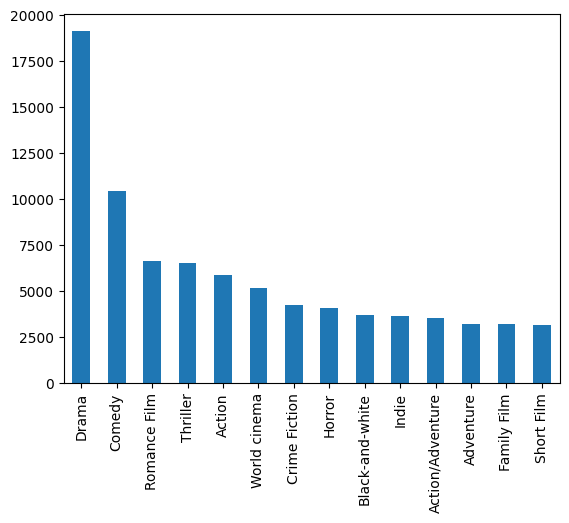

In [26]:
# df_labels = movies_genres_df[genres_labels]
label_counts = genres_binary_df.sum().to_dict()
df_labels[sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar()

In [27]:
# correlation plot for labels
corr = df_labels.corr()
corr.style.background_gradient(cmap='coolwarm')

,Romance Film,Horror,Indie,Action,World cinema,Comedy,Family Film,Adventure,Black-and-white,Short Film,Action/Adventure,Thriller,Crime Fiction,Drama
Romance Film,1.000000,-0.123257,0.035898,-0.082219,0.114523,0.126791,-0.064971,-0.045832,-0.009910,-0.110862,-0.070006,-0.103014,-0.059482,0.193136
Horror,-0.123257,1.000000,0.008887,-0.047163,-0.004261,-0.101235,-0.085874,-0.046664,-0.042037,-0.070863,-0.034543,0.162129,-0.054860,-0.211375
Indie,0.035898,0.008887,1.000000,-0.046432,-0.040554,0.097246,-0.066154,-0.038276,0.067475,-0.006496,-0.020840,0.010110,0.031349,0.080262
Action,-0.082219,-0.047163,-0.046432,1.000000,-0.000098,-0.056029,-0.048651,0.222106,-0.053496,-0.098633,0.529286,0.238240,0.174685,-0.078189
World cinema,0.114523,-0.004261,-0.040554,-0.000098,1.000000,-0.021114,-0.083714,-0.038442,-0.063109,-0.101201,0.123594,0.036963,-0.003590,0.177039
Comedy,0.126791,-0.101235,0.097246,-0.056029,-0.021114,1.000000,0.130980,-0.007933,0.066616,0.062740,-0.008334,-0.156797,-0.050052,-0.175615
Family Film,-0.064971,-0.085874,-0.066154,-0.048651,-0.083714,0.130980,1.000000,0.201045,-0.025022,0.200046,-0.045650,-0.104427,-0.078127,-0.096901
Adventure,-0.045832,-0.046664,-0.038276,0.222106,-0.038442,-0.007933,0.201045,1.000000,0.014363,-0.066792,0.178195,-0.001117,-0.020037,-0.062957
Black-and-white,-0.009910,-0.042037,0.067475,-0.053496,-0.063109,0.066616,-0.025022,0.014363,1.000000,0.113898,-0.044218,-0.040223,0.014682,0.002092
Short Film,-0.110862,-0.070863,-0.006496,-0.098633,-0.101201,0.062740,0.200046,-0.066792,0.113898,1.000000,-0.082853,-0.108752,-0.088309,-0.210639


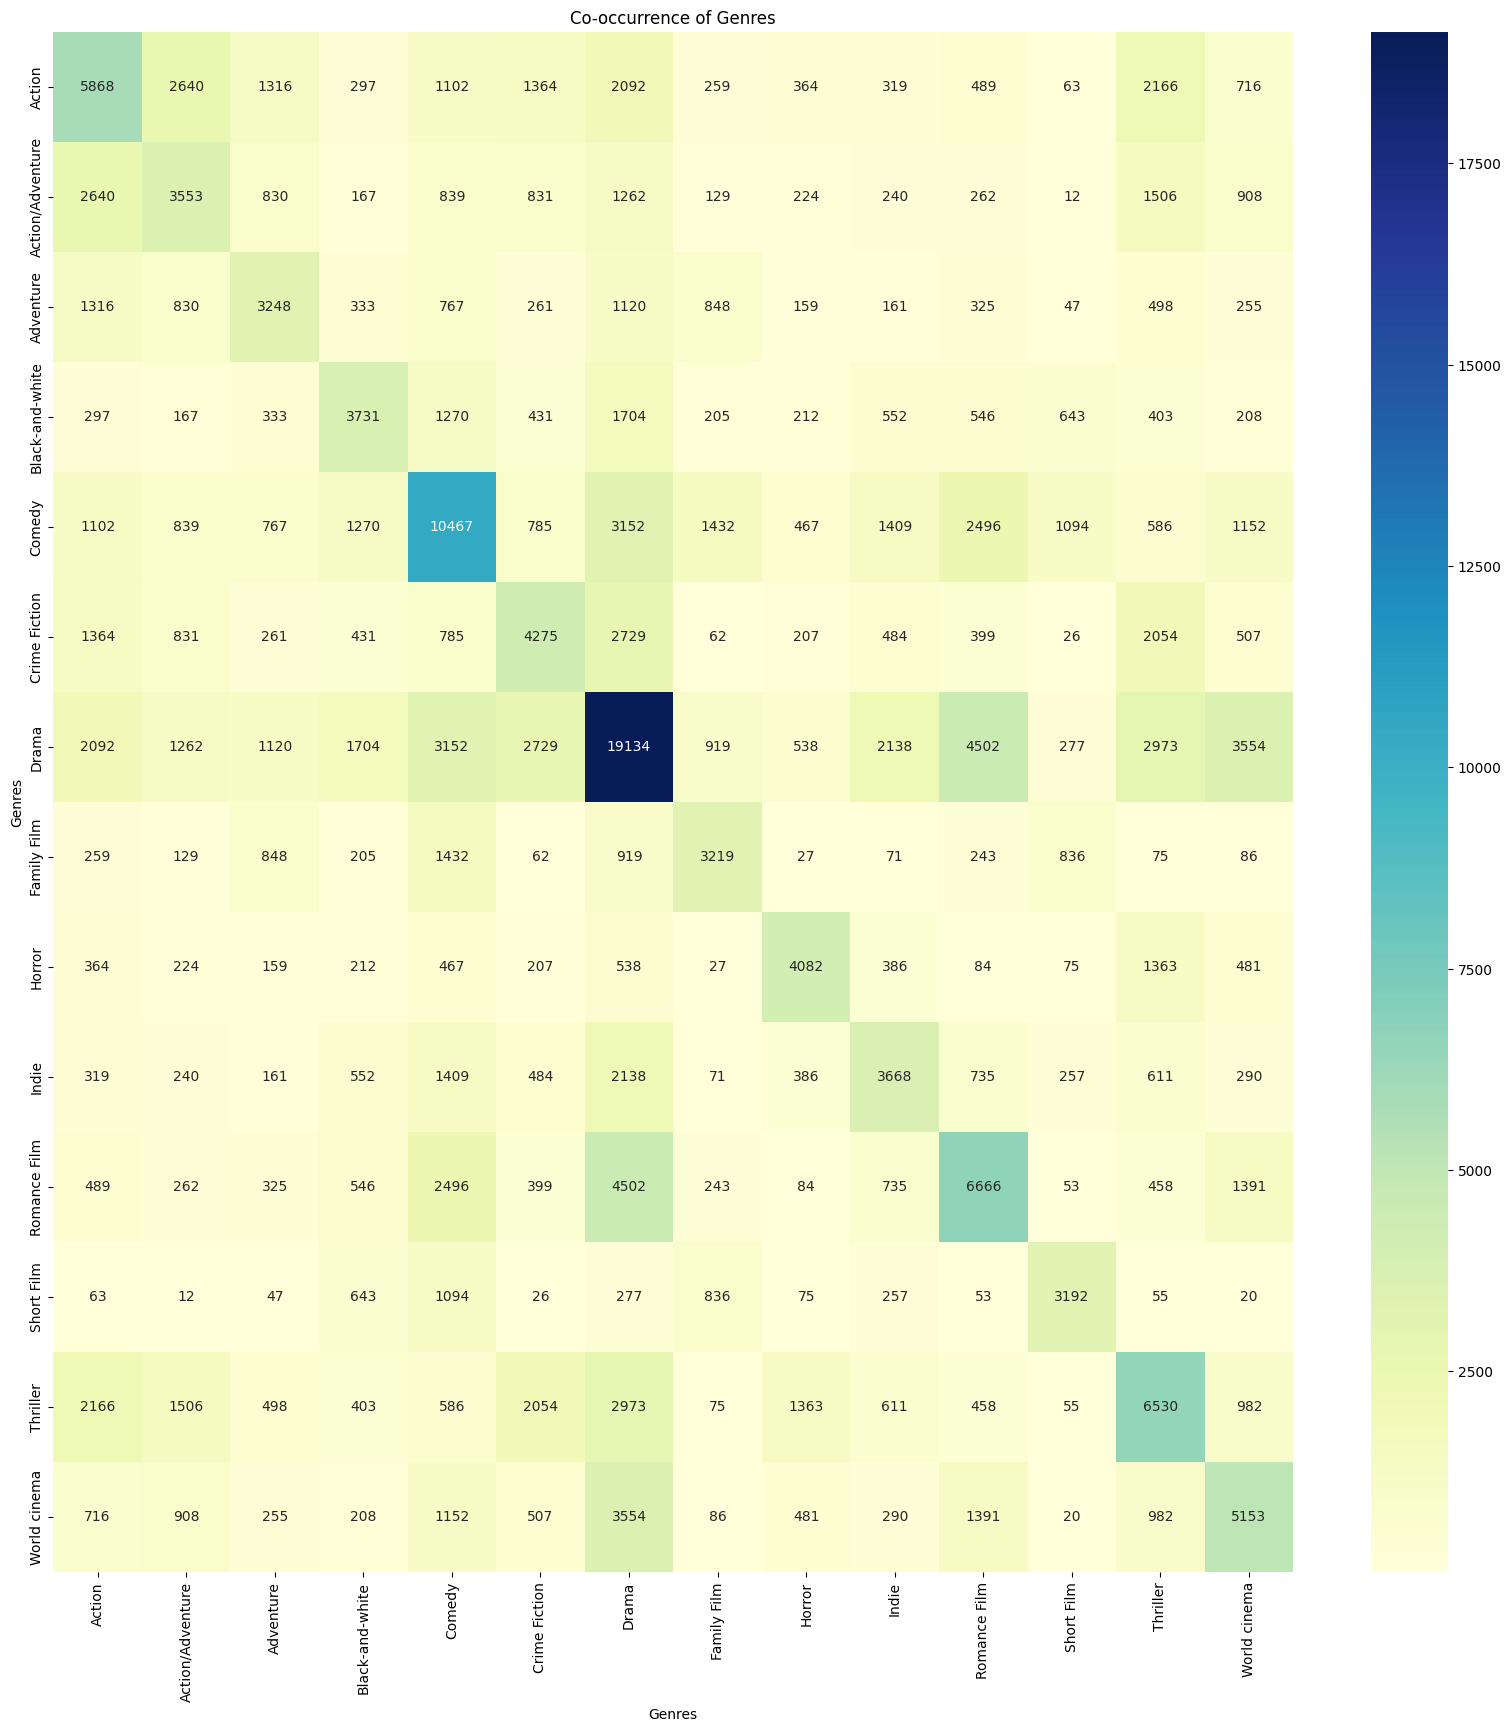

In [28]:
co_occurrence_matrix = genres_binary_df.T.dot(genres_binary_df)
plt.figure(figsize=(20, 20))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Co-occurrence of Genres')
plt.xlabel('Genres')
plt.ylabel('Genres')
plt.show()


In [29]:
# conditional probability matrix
def build_conditional_prob_matrix(df, labels):
    cooc = df[labels].values.T.dot(df[labels].values)
    cooc_norm = cooc.copy().astype(np.float32)
    for i in range(cooc_norm.shape[0]):
        cooc_norm[:, i] /= cooc[i, i]
    return cooc_norm

cooc_norm = build_conditional_prob_matrix(movies_genres_df, genres_labels)
cooc_df = pd.DataFrame(cooc_norm, columns = genres_labels, index = genres_labels)
cooc_df.style.background_gradient(cmap = 'coolwarm')

,Romance Film,Horror,Indie,Action,World cinema,Comedy,Family Film,Adventure,Black-and-white,Short Film,Action/Adventure,Thriller,Crime Fiction,Drama
Romance Film,1.000000,0.020578,0.200382,0.083333,0.269940,0.238464,0.075489,0.100062,0.146341,0.016604,0.073741,0.070138,0.093333,0.235288
Horror,0.012601,1.000000,0.105234,0.062031,0.093344,0.044616,0.008388,0.048953,0.056821,0.023496,0.063045,0.208729,0.048421,0.028117
Indie,0.110261,0.094561,1.000000,0.054363,0.056278,0.134614,0.022057,0.049569,0.147950,0.080514,0.067549,0.093568,0.113216,0.111738
Action,0.073357,0.089172,0.086968,1.000000,0.138948,0.105283,0.080460,0.405172,0.079603,0.019737,0.743034,0.331700,0.319064,0.109334
World cinema,0.208671,0.117834,0.079062,0.122018,1.000000,0.110060,0.026716,0.078510,0.055749,0.006266,0.255559,0.150383,0.118596,0.185743
Comedy,0.374437,0.114405,0.384133,0.187798,0.223559,1.000000,0.444859,0.236145,0.340391,0.342732,0.236138,0.089740,0.183626,0.164733
Family Film,0.036454,0.006614,0.019357,0.044138,0.016689,0.136811,1.000000,0.261084,0.054945,0.261905,0.036307,0.011485,0.014503,0.048030
Adventure,0.048755,0.038951,0.043893,0.224267,0.049486,0.073278,0.263436,1.000000,0.089252,0.014724,0.233605,0.076263,0.061053,0.058535
Black-and-white,0.081908,0.051935,0.150491,0.050613,0.040365,0.121334,0.063684,0.102525,1.000000,0.201441,0.047003,0.061715,0.100819,0.089056
Short Film,0.007951,0.018373,0.070065,0.010736,0.003881,0.104519,0.259708,0.014470,0.172340,1.000000,0.003377,0.008423,0.006082,0.014477


In [30]:
TARGET_SAMPLES = 3000
target_counts = [TARGET_SAMPLES for _ in genres_labels]
optimal_samples, residuals = nnls(cooc_norm, target_counts)
optimal_samples = optimal_samples.round().astype(np.int32)
optimal_samples

array([ 734, 2447, 1115,    0,  715,    0, 1148, 1593, 1129, 2288, 1808,
          0, 1031,    0], dtype=int32)

In [31]:
# using NNLS, sampling the dataset
def fancy_sample(df, labels, target_count, cond_prob):
    target_counts = np.array([target_count for _ in labels])
    optimal_samples, residuals = nnls(cond_prob, target_counts)
    optimal_samples = np.ceil(optimal_samples).astype(np.int32)

    df_subs = []
    for i, label in enumerate(labels):
        sub_df = df[df[label] == 1]
        df_subs.append(sub_df.sample(optimal_samples[i], 
                                     replace = len(sub_df) < optimal_samples[i]))
    sampled_df = pd.concat(df_subs)
    return sampled_df

resampled_df = fancy_sample(movies_genres_df, genres_labels, TARGET_SAMPLES, cooc_norm)
resampled_df_labels = resampled_df[genres_labels]

<Axes: >

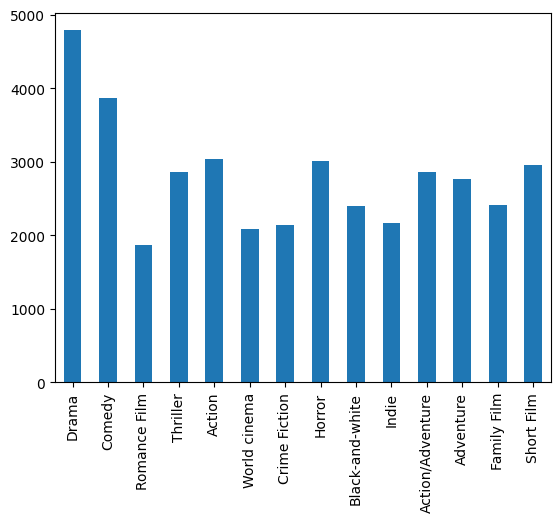

In [32]:
resampled_df[sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar()

In [17]:
resampled_df

,movie_id,movie_name,Action,Action/Adventure,Adventure,Black-and-white,Comedy,Crime Fiction,Drama,Family Film,Horror,Indie,Romance Film,Short Film,Thriller,World cinema
33065,20475330,Undertow,0,0,0,1,0,0,0,0,0,0,0,0,1,0
20904,3987540,The Flying Deuces,0,0,0,1,1,0,0,0,0,0,0,0,0,0
24681,1662366,The Long Night,0,0,0,1,0,0,1,0,0,0,0,0,1,0
21958,5531874,The Vigilante Fighting Hero of the West,1,0,1,1,0,1,0,0,0,0,0,0,0,0
5677,24166341,Rapture,0,0,0,1,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8111,6879392,The Ultimate Silly Song Countdown,0,0,0,0,1,0,0,0,0,0,0,1,0,0
35695,19347652,Lazy Days,0,0,0,1,1,0,0,1,0,0,0,1,0,0
21736,27567823,Shackleton's Antarctic Adventure,0,0,0,0,0,0,0,0,0,0,0,1,0,0
27028,3227389,Hockey Homicide,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [20]:
resampled_df.to_csv('./Dataset_MovieSummaries/balanced_dataset.csv')

In [16]:
# analyse the different genre combinations
# genre_counts_df = movies_genre.groupby('genres').size().reset_index(name='count').sort_values(by='count', ascending=False)
# genre_counts_df
# genre_counts_df[genre_counts_df['count']>500]

In [35]:
dataset = pd.merge(resampled_df, summary_df, on='movie_id', how='inner')
dataset

,movie_id,movie_name,Action,Action/Adventure,Adventure,Black-and-white,Comedy,Crime Fiction,Drama,Family Film,Horror,Indie,Romance Film,Short Film,Thriller,World cinema,summary
0,20309964,First Love,0,0,0,1,0,0,0,0,0,0,1,0,0,0,Constance Harding is an unhappy orphan who wil...
1,31981147,The Place at the Coast,0,0,0,0,0,0,1,0,0,0,1,0,0,0,Teenager Ellie is distressed by forces that th...
2,19626582,Chinna Mapillai,0,0,0,0,0,0,1,0,0,0,1,0,0,0,Prabhu is a kind-hearted poor man who works as...
3,11270479,Tera Jadoo Chal Gaya,0,0,0,0,0,0,1,0,0,0,1,0,0,1,"On a visit to scenic Agra, Pooja meets with a..."
4,2428862,Take My Eyes,0,0,0,0,0,0,1,0,0,0,1,0,0,1,"Pilar, a meek housewife living in Toledo, gath..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14009,1873017,Boxcar Bertha,0,0,0,0,0,1,1,0,0,0,0,0,1,0,Besides the name of the heroine and her freigh...
14010,21472992,Black Day Blue Night,0,0,0,0,0,1,0,0,0,0,0,0,1,0,A wife's husband is cheating on her. She decid...
14011,220521,Diamonds,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Charles Hodgson is a British aristocrat who de...
14012,8964827,Running Time,0,0,0,0,0,1,0,0,0,0,0,0,1,0,A prison inmate receives early release only t...


In [47]:
def cleaner (summary):
    summary = summary.replace('"','')
    summary = summary.replace("'"," ")
    return summary

dataset['summary'] = dataset['summary'].apply(cleaner)


In [48]:
dataset['summary']

0        Constance Harding is an unhappy orphan who wil...
1        Teenager Ellie is distressed by forces that th...
2        Prabhu is a kind-hearted poor man who works as...
3        On a visit to scenic Agra, Pooja  meets with a...
4        Pilar, a meek housewife living in Toledo, gath...
                               ...                        
14009    Besides the name of the heroine and her freigh...
14010    A wife s husband is cheating on her. She decid...
14011    Charles Hodgson is a British aristocrat who de...
14012    A prison inmate  receives early release only t...
14013    The film takes place in Marseille, France, and...
Name: summary, Length: 14014, dtype: object

In [49]:
dataset.to_csv('./Dataset_MovieSummaries/Dataset.csv')